In [103]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy
from collections import defaultdict
import joblib
from collections import Counter
import seaborn as sns

In [2]:
data = pd.read_csv('data/jeopardy.csv')
red_data = data.dropna()
red_data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [3]:
new_cols = {s:s.strip() for s in red_data.columns}
red_data = red_data.rename(columns=new_cols)

In [4]:
# data = data.rename(columns={' Question': 'question', ' Air Date': 'air_date', ' Round':'round'})
red_data['AirDate'] = pd.to_datetime(red_data['Air Date'])
red_data['year'] = pd.DatetimeIndex(red_data['Air Date']).year  # add year feature
red_data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,AirDate,year
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004-12-31,2004
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004-12-31,2004
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,2004-12-31,2004
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004-12-31,2004
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004-12-31,2004


In [5]:
def has_link(cell):
    if '<a' in cell and 'a>' in cell:
        return True
        #link_text = cell[cell.index('<a'):cell.index('a>') + 2]
       # return cell.replace(link_text, '')
    else:
        return False

In [6]:
red_data['Has Link'] = red_data['Question'].apply(lambda x: has_link(x))
red_data = red_data[red_data['Has Link'] == False]

In [7]:
round_list = red_data['Round'].unique()

In [8]:
j_data = red_data[red_data['Round'] == 'Jeopardy!']
dj_data = red_data[red_data['Round'] == 'Double Jeopardy!']
fj_data = red_data[red_data['Round'] == 'Final Jeopardy!']

In [9]:
years = red_data.year.unique()
years

array([2004, 2010, 2000, 2006, 2009, 1996, 2007, 1997, 2002, 2003, 2001,
       1990, 1999, 2008, 2011, 2005, 1998, 2012, 1992, 1986, 1985, 1991,
       1993, 1994, 1988, 1987, 1995, 1984, 1989])

In [30]:
def get_top_k(topic_idx, topic, components, k):
    top_features = []
    for t in topic.argsort()[-k:]:
        if components[topic_idx, t] < 0.5:
            break
        else:
            top_features.append(t)
    return reversed(top_features)

def is_integer(cell):
    if int(cell) == float(cell):
        return True
    else:
        return False
    
def find_largest_divisor(num):
    res = []
    for i in range(1, num):
        if is_integer(num/i):
            res.append(i)
    return res[len(res)//2], num//res[len(res)//2]


def plot_top_words(num_topics, X, df, feature_names, n_top_words, title):
    res = []
    lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
    model = lda.fit(X)
    doc_topic_prob = model.transform(X)
    doc_prob = defaultdict(int)
    topic_docs = defaultdict(list)
    info = defaultdict(list)
    for index, row in enumerate(doc_topic_prob):
        doc_prob[np.argmax(row)] += 1
        topic_docs[np.argmax(row)].append(df['Norm Text List'].iloc[index])
    total = len(doc_topic_prob)
    row, col = find_largest_divisor(num_topics)
    fig, axes = plt.subplots(row, col, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = list(get_top_k(topic_idx, topic, model.components_, num_topics))#topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        info[topic_idx] = top_features
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        prob = 100 * doc_prob[topic_idx]/total
        res.append(prob)
        ax.set_title(f'Topic {topic_idx +1} | {prob:.2f}%',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.tight_layout()
    plt.show()
    return res, topic_docs, model, info

# def plot_top_words(num_topics, X, feature_names, n_top_words, title):
#     res = []
#     lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online')
#     model = lda.fit(X)
#     doc_topic_prob = model.transform(X)
#     doc_prob = defaultdict(int)
#     for row in doc_topic_prob:
#         doc_prob[np.argmax(row)] += 1
#     total = len(doc_topic_prob)
#     row, col = find_largest_divisor(num_topics)
#     fig, axes = plt.subplots(row, col, figsize=(30, 15), sharex=True)
#     axes = axes.flatten()
#     for topic_idx, topic in enumerate(model.components_):
# #         print(topic_idx)
# #         print(len(topic))
# #         print(model.components_)
# #         print(len(model.components_))
#         top_features_ind = list(get_top_k(topic_idx, topic, model.components_, num_topics))#topic.argsort()[:-n_top_words - 1:-1]
#         top_features = [feature_names[i] for i in top_features_ind]
#         weights = topic[top_features_ind]
#         ax = axes[topic_idx]
#         ax.barh(top_features, weights, height=0.7)
#         prob = 100 * doc_prob[topic_idx]/total
#         res.append(prob)
#         ax.set_title(f'Topic {topic_idx +1} | {prob:.2f}%',
#                      fontdict={'fontsize': 30})
#         ax.invert_yaxis()
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for i in 'top right left'.split():
#             ax.spines[i].set_visible(False)
#         fig.suptitle(title, fontsize=40)
#     plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
#     plt.show()
#     return res

# Question 2

In [11]:
### Preprocessing:
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nlp = spacy.load("en")
nlp.max_length = 3349390

# def get_noun_chunks(cell):
#     doc = nlp(cell)
#     res = []
#     for noun in doc.noun_chunks: # use np instead of np.text
#         res.append(str(noun))
        
#     return ' '.join(res)


def normalize_text(cell):
    # Remove punctuation:
    cell = cell.lower()
    cell = cell.translate(str.maketrans('', '', string.punctuation))
    wordnet_lemmatizer = WordNetLemmatizer()
    token_list = word_tokenize(cell)
    return ' '.join([wordnet_lemmatizer.lemmatize(w) for w in token_list if w not in stopwords.words('english')])


# jeopardy_df['Text Nouns'] = jeopardy_df['Text'].apply(lambda x: get_noun_chunks(x)) # 13 minutes
# jeopardy_df['Norm Text Nouns'] = jeopardy_df['Text Nouns'].apply(lambda x: normalize_text(x)) # 3 minutes


# corpus = jeopardy_df[jeopardy_df['Year'] == '2001']['Norm Text Nouns'].values
# vectorizer = TfidfVectorizer(stop_words={'english'})#, max_df=0.8)
# X = vectorizer.fit_transform(corpus)

## Jeopardy questions grouped by question value

In [89]:
red_data['Text'] = red_data['Question'] + ' ' + red_data['Answer']
j_data = red_data[red_data['Round'] == 'Jeopardy!']

In [13]:
# These are the possible values for jeopardy questions (excluding daily doubles)
poss_values = ['$200', '$400', '$600', '$800', '$1000',  '$400', '$800', '$1200', '$1600', '$2000']

In [14]:
j_data.Value.unique()

array(['$200', '$400', '$600', '$800', '$2,000', '$1000', '$100', '$300',
       '$500', '$1,200', '$2,200', '$3,000', '$1,600', '$1,500', '$1,800',
       '$1,000', '$1,400', '$700', '$4,800', '$2,500', '$1,300', '$900',
       '$3,600', '$3,200', '$2,800', '$1,100', '$5,000', '$3,389',
       '$5,600', '$3,800', '$5', '$2,600', '$2,300', '$1,263', '$2,400',
       '$6,600', '$4,200', '$2,700', '$350', '$3,400', '$4,000', '$1,700',
       '$3,989', '$2,100', '$750', '$1,900', '$250', '$3,100', '$5,200',
       '$3,500', '$4,600', '$796', '$6,000', '$2,900'], dtype=object)

In [15]:
j_data = j_data[j_data['Value'].isin(poss_values)]

In [35]:
# j_data_val = j_data.groupby(by=['Value']).agg({'Text': lambda x: ' '.join(x)})


j_data_val = j_data.copy()

In [17]:
j_data_val.head()

,Text
Value,
$1000,This Asian political party was founded in 1885...
$200,"For the last 8 years of his life, Galileo was ..."
$400,Built in 312 B.C. to link Rome & the South of ...
$600,In 1000 Rajaraja I of the Cholas battled to ta...
$800,Karl led the first of these Marxist organizati...


In [37]:
# j_data_val['Text Nouns'] = j_data_val['Text'].apply(lambda x: get_noun_chunks(x)) 
j_data_val['Norm Text'] = j_data_val['Text'].apply(lambda x: normalize_text(x))
j_data_val['Norm Text List'] = j_data_val['Norm Text'].apply(lambda x: x.split(' '))

In [38]:
j_data_val.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,AirDate,year,Has Link,Text,Norm Text,Norm Text List
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,2004-12-31,2004,False,"For the last 8 years of his life, Galileo was ...",last 8 year life galileo house arrest espousin...,"[last, 8, year, life, galileo, house, arrest, ..."
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,2004-12-31,2004,False,No. 2: 1912 Olympian; football star at Carlisl...,2 1912 olympian football star carlisle indian ...,"[2, 1912, olympian, football, star, carlisle, ..."
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,2004-12-31,2004,False,The city of Yuma in this state has a record av...,city yuma state record average 4055 hour sunsh...,"[city, yuma, state, record, average, 4055, hou..."
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,2004-12-31,2004,False,"In 1963, live on ""The Art Linkletter Show"", th...",1963 live art linkletter show company served b...,"[1963, live, art, linkletter, show, company, s..."
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,2004-12-31,2004,False,"Signer of the Dec. of Indep., framer of the Co...",signer dec indep framer constitution mass seco...,"[signer, dec, indep, framer, constitution, mas..."


In [39]:
j_data_val.shape

(74044, 13)

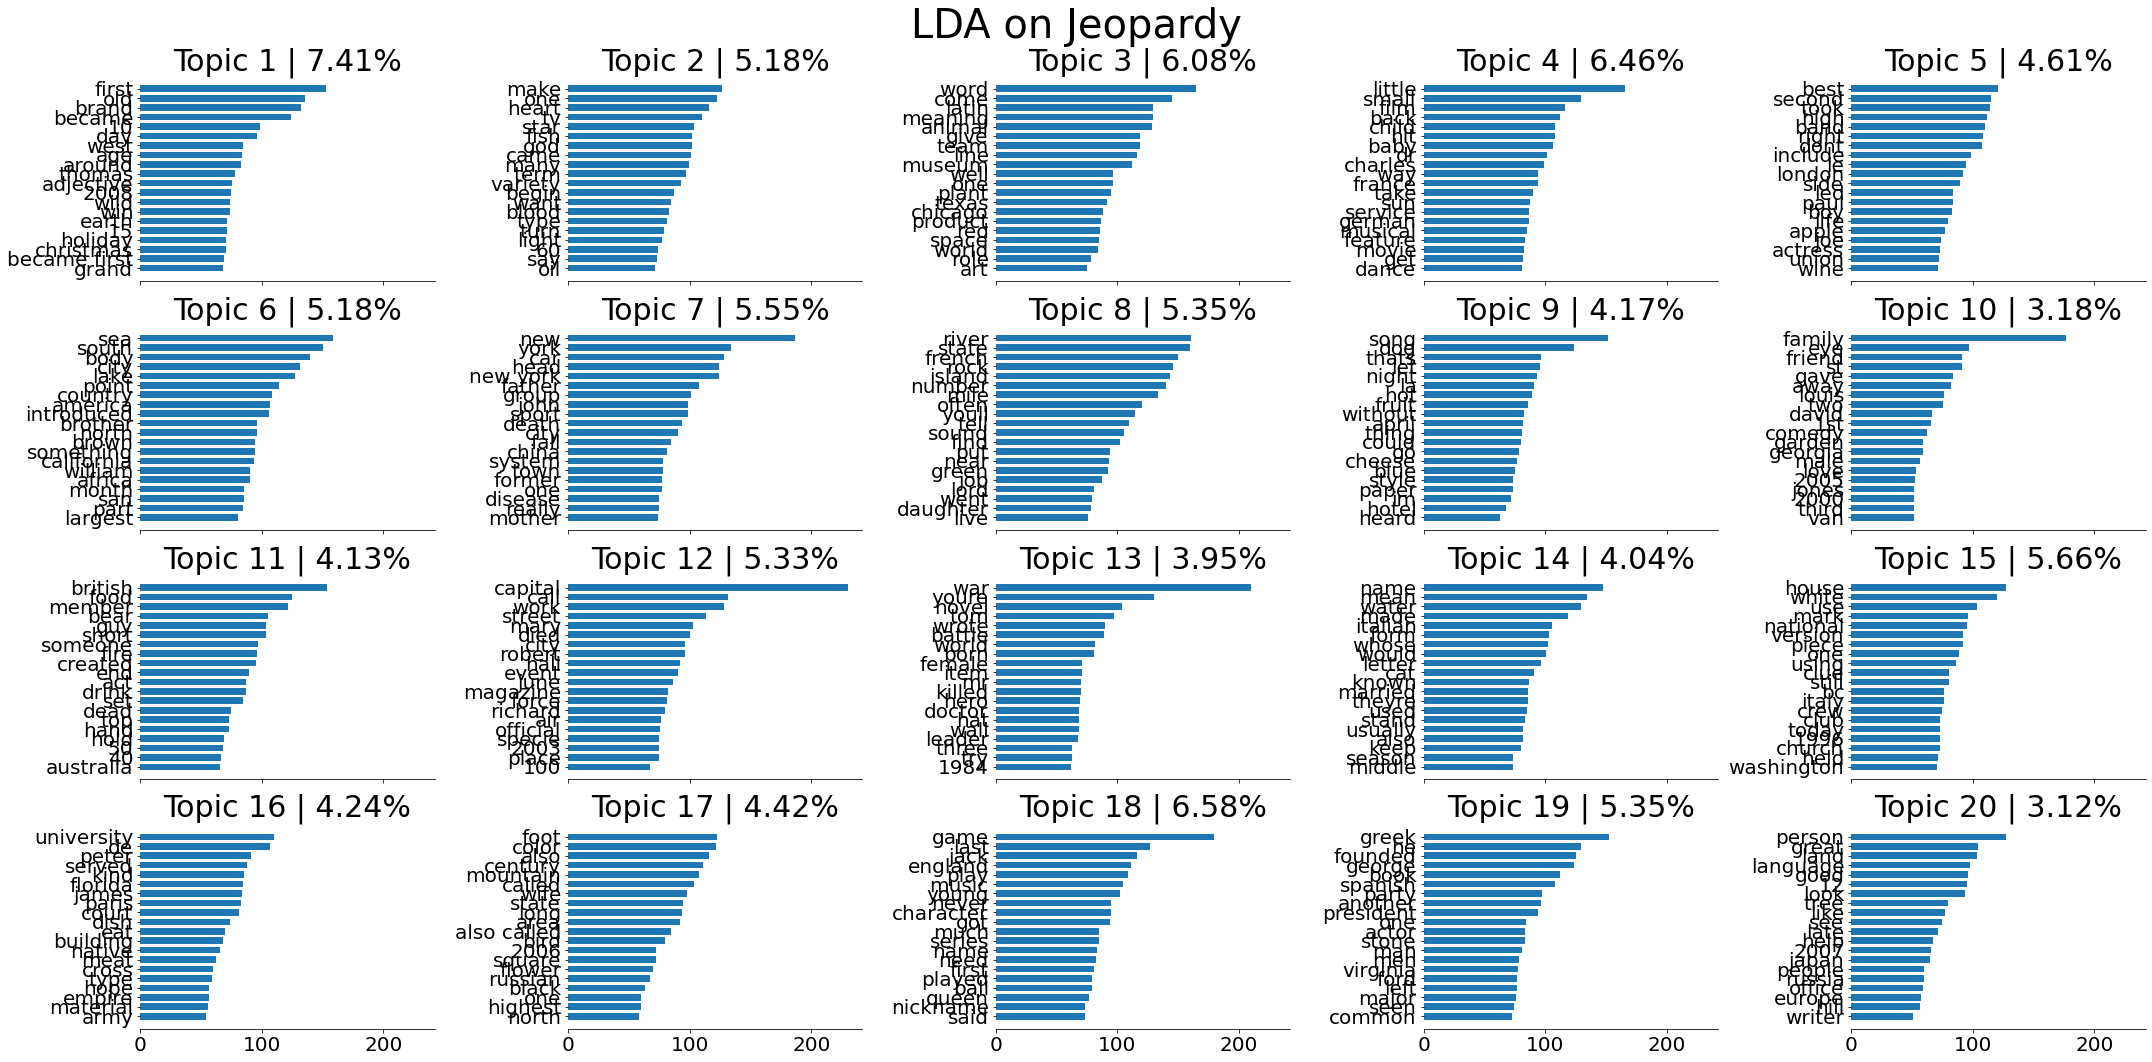

AttributeError: 'list' object has no attribute 'lower'

In [40]:
topics = defaultdict(list)
distribution = defaultdict(list)
for value in np.unique(j_data_val.index):
    num_topics = 20
    # 1. Get corpus subset
    subset = j_data_val
    corpus = subset['Norm Text List'].values
    corpus = [' '.join(i) for i in corpus]
    # 2. TFIDF and Vocab
    vectorizer = TfidfVectorizer(stop_words={'english'}, ngram_range=(1,3), max_features=10000)
    vectorizer.fit(corpus)
    X = vectorizer.transform(corpus)
    Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}
    # 3. LDA model
    odds, topic_docs, lda, info = plot_top_words(num_topics, X, subset, Vocab, 15, f"LDA on Jeopardy")
    # 4. append odds
    distribution[value] = odds
    # 4. Get user input for each topic:

    for i in range(num_topics):
        preds = lda.transform(vectorizer.transform(topic_docs[i]))
        probs = np.array([np.max(p)/1 for p in preds])

        for ind_ in probs.argsort()[-5:]:
            doc = topic_docs[i][ind_]
            print(doc)
    #             preds = lda.transform(vectorizer.transform([doc]))
    #             conf = np.round(np.max(preds)/1,2)
    #         print('\n\n'.join(doc))#, np.argmax(lda.transform(vectorizer.transform([doc]))), conf)
        print('Word:', info[i])
        topic = input(f"What topic in topic {i+1}?")
        topics[decade].append(topic)
        print()
        print()

In [ ]:
# j_data_val['Norm_Doc'] = j_data_val['Document'].apply(lambda x: normalize_text(x))

In [ ]:
# corpus = jeopardy_df[jeopardy_df['Year'] == '2001']['Norm Text Nouns'].values

In [ ]:
# corpus = [text.lower() for text in j_data_val['Norm Text Nouns'].values]
# # corpus = jeopardy_df[jeopardy_df['Year'] == '2001']['Norm Text Nouns'].values

# vectorizer = TfidfVectorizer(stop_words={'english'})#, max_df=0.8)
# X = vectorizer.fit_transform(corpus)

In [ ]:
# vectorizer = TfidfVectorizer(stop_words={'english'}, max_df=0.8)
# X = vectorizer.fit_transform(corpus)

In [ ]:
from collections import defaultdict
topics = defaultdict(list)
for t in range(NUM_TOPICS):
    # val > 0.5 -> it's part of the topic
    for index, val in enumerate(word_topic[t].argsort()[-15:-1]):#[0,:]):
        topics[t].append(Vocab[val])

In [ ]:
topics

In [ ]:
j_data_val.index

In [ ]:
topics = defaultdict(list)
distribution = defaultdict(list)
for value in np.unique(j_data_val.index):
#     corpus = j_data_val[j_data_val['Value'] == value]['Norm Text Nouns'].values
    corpus = j_data_val[j_data_val.index == value]['Norm Text List'].values
#     print(corpus)
    corpus = [' '.join(i) for i in corpus]
    
    vectorizer = TfidfVectorizer(stop_words={'english'}, max_features=2000)
    X = vectorizer.fit_transform(corpus)
    Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}
    
    
    
    odds = plot_top_words(8, X, Vocab, 15, f'LDA on Value: {value}')
    
    distribution[value] = odds
    
    for i in range(10):
        topic = input(f'What topic is topic {i+1}?')
        topics[value].append(topic)

In [ ]:
# tfidf_feature_names = vectorizer.get_feature_names()
# plot_top_words(lda, tfidf_feature_names, 10,
#                'Topics in LDA model')

## Double Jeopardy questions grouped by question value

In [ ]:
dj_data.Value.unique()

In [ ]:
dj_values = ['$400', '$800', '$1200', '$1500', '$2000']

In [ ]:
dj_data = dj_data[dj_data['Value'].isin(dj_values)]

In [ ]:
dj_data_val = dj_data.groupby(by=['Value']).agg({'Category': lambda x: ' '.join(x),
                                               'Question': lambda x: ' '.join(x),
                                               'Answer': lambda x: ' '.join(x)})

In [ ]:
dj_data_val['Document'] = dj_data_val.Category + ' ' + dj_data_val.Question + ' ' + dj_data_val.Answer

In [ ]:
dj_data_val['Norm_Doc'] = dj_data_val['Document'].apply(lambda x: normalize_text(x))

In [ ]:
corpus = [text.lower() for text in dj_data_val['Norm_Doc'].values]

In [ ]:
vectorizer = TfidfVectorizer(stop_words={'english'}, max_df=0.8)
X = vectorizer.fit_transform(corpus)

Vocab = {index:word for index, word in enumerate(vectorizer.get_feature_names())}

In [ ]:
NUM_TOPICS = 5
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, learning_method='online')

In [ ]:
lda.fit(X)
word_topic = lda.components_

In [ ]:
from collections import defaultdict
topics = defaultdict(list)
for t in range(NUM_TOPICS):
    # val > 0.5 -> it's part of the topic
    for index, val in enumerate(word_topic[t].argsort()[-15:-1]):#[0,:]):
        topics[t].append(Vocab[val])

In [ ]:
topics

In [ ]:
# tfidf_feature_names = vectorizer.get_feature_names()
# plot_top_words(lda, tfidf_feature_names, 10,
#                'Topics in LDA model')

## Question 2

In [54]:
# Models imported from question 1

lda = joblib.load('lda_model.jl')
vectorizer = joblib.load('tfidf_vector.jl')
topics = joblib.load('topics.jl')

/Users/kylebrooks/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/kylebrooks/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/kylebrooks/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


### Single jeopardy split up by question value

In [115]:
labels = {}
dollar_values = ['$200', '$400', '$600', '$800', '$1000'] #, '$400', '$800', '$1200', '$1600', '$2000']

for amount in dollar_values:
    temp = []
    tfidf = vectorizer.transform(j_data_val[j_data_val.Value == amount]['Norm Text'].values)
    for item in lda.transform(tfidf):    
        temp.append(topics[np.argmax(item)])
    
    labels[amount] = temp

In [116]:
result = {}
for k, v in labels.items():
    result[k] = Counter(v).most_common(4)

In [117]:
result

{'$200': [('History/Geography', 1702),
  ('Entertainment', 1638),
  ('New York City', 1072),
  ('US Famous People', 1043)],
 '$400': [('History/Geography', 1653),
  ('Entertainment', 1599),
  ('New York City', 1009),
  ('Art', 963)],
 '$600': [('History/Geography', 914),
  ('Entertainment', 847),
  ('Art', 582),
  ('Geography', 579)],
 '$800': [('History/Geography', 975),
  ('Entertainment', 832),
  ('Art', 557),
  ('New York City', 547)],
 '$1000': [('History/Geography', 975),
  ('Entertainment', 899),
  ('Geography', 578),
  ('Etymology/History', 536)]}

<bound method Figure.tight_layout of <Figure size 432x1440 with 5 Axes>>

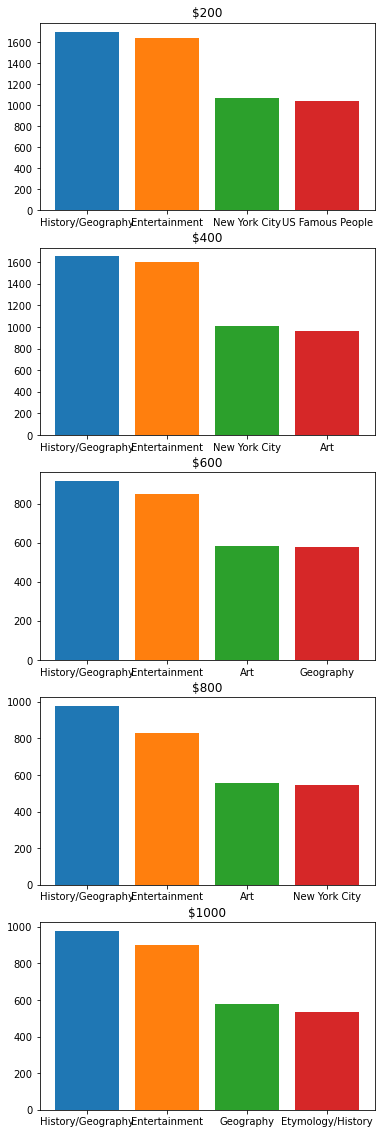

In [128]:
fig, ax = plt.subplots(5, 1, figsize=(6, 20))

i = 0
for amount in dollar_values:
    for topic, count in result[amount]:
        ax[i].bar(topic, count)
        ax[i].set_title(amount)
    i+=1
fig.tight_layout

As one can see, for the various values of Jeopardy questions, the two top categories (History/Geography and Entertainment) are identical. We notice that geography and etymology questions are more common in questions with higher point values. This could likely be due to the fact that etymology tends to be a difficult subject.

- Additionally it seems that the topic "New York City" drops off after $400, perhaps because NYC questions are too familiar for the average person.

- Finally, the prevalence of history/geography increases with monetary value, as it become

### Double jeopardy split up by question value

In [129]:
dj_data = red_data[red_data['Round'] == 'Double Jeopardy!']

In [130]:
dj_data.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,AirDate,year,Has Link,Text
30,4680,2004-12-31,Double Jeopardy!,PRESIDENTIAL STATES OF BIRTH,$400,California,Nixon,2004-12-31,2004,False,California Nixon
31,4680,2004-12-31,Double Jeopardy!,AIRLINE TRAVEL,$400,It can be a place to leave your puppy when you...,a kennel,2004-12-31,2004,False,It can be a place to leave your puppy when you...
32,4680,2004-12-31,Double Jeopardy!,THAT OLD-TIME RELIGION,$400,"He's considered the author of the Pentateuch, ...",Moses,2004-12-31,2004,False,"He's considered the author of the Pentateuch, ..."
33,4680,2004-12-31,Double Jeopardy!,MUSICAL TRAINS,$400,Steven Tyler of this band lent his steamin' vo...,Aerosmith,2004-12-31,2004,False,Steven Tyler of this band lent his steamin' vo...
34,4680,2004-12-31,Double Jeopardy!,"""X""s & ""O""s",$400,Around 100 A.D. Tacitus wrote a book on how th...,oratory,2004-12-31,2004,False,Around 100 A.D. Tacitus wrote a book on how th...


In [131]:
dj_data['Norm Text'] = dj_data['Text'].apply(lambda x: normalize_text(x))
dj_data['Norm Text List'] = dj_data['Norm Text'].apply(lambda x: x.split(' '))

<ipython-input-131-4baa291e3da3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dj_data['Norm Text'] = dj_data['Text'].apply(lambda x: normalize_text(x))
<ipython-input-131-4baa291e3da3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dj_data['Norm Text List'] = dj_data['Norm Text'].apply(lambda x: x.split(' '))


In [132]:
labels = {}
dollar_values = ['$400', '$800', '$1200', '$1600', '$2000'] #, '$400', '$800', '$1200', '$1600', '$2000']

for amount in dollar_values:
    temp = []
    tfidf = vectorizer.transform(dj_data[dj_data.Value == amount]['Norm Text'].values)
    for item in lda.transform(tfidf):    
        temp.append(topics[np.argmax(item)])
    
    labels[amount] = temp

In [133]:
result = {}
for k, v in labels.items():
    result[k] = Counter(v).most_common(4)

In [134]:
result

{'$400': [('History/Geography', 1917),
  ('Entertainment', 1624),
  ('Geography', 1092),
  ('New York City', 1034)],
 '$800': [('History/Geography', 1736),
  ('Entertainment', 1542),
  ('Geography', 948),
  ('World Leaders', 935)],
 '$1200': [('History/Geography', 960),
  ('Entertainment', 836),
  ('World Leaders', 541),
  ('Geography', 528)],
 '$1600': [('History/Geography', 940),
  ('Entertainment', 794),
  ('Geography', 552),
  ('World Leaders', 530)],
 '$2000': [('History/Geography', 967),
  ('Entertainment', 824),
  ('World Leaders', 531),
  ('Geography', 517)]}

<bound method Figure.tight_layout of <Figure size 432x1440 with 5 Axes>>

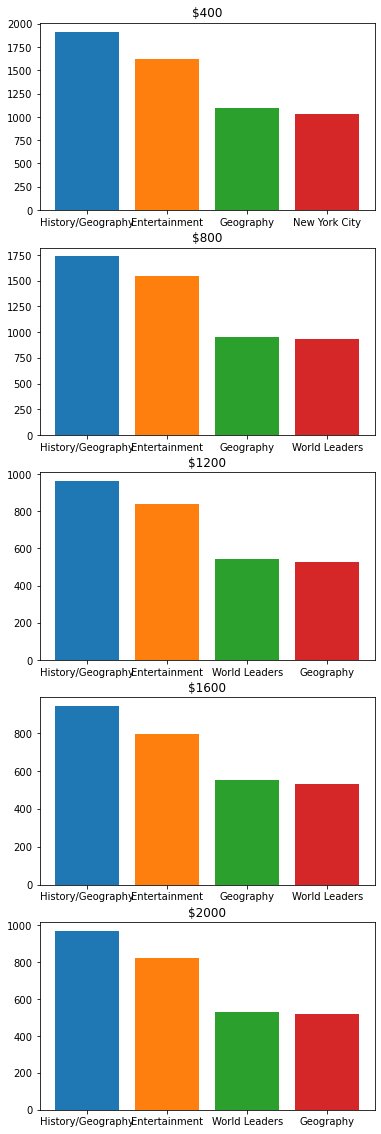

In [135]:
fig, ax = plt.subplots(5, 1, figsize=(6, 20))

i = 0
for amount in dollar_values:
    for topic, count in result[amount]:
        ax[i].bar(topic, count)
        ax[i].set_title(amount)
    i+=1
fig.tight_layout

As one can see, for the various values of Double Jeopardy questions again the top two categories remain the same with World Leaders and Geography become more common as the question increases in value.

### (b)

In [140]:
j_data['Norm Text'] = j_data['Text'].apply(lambda x: normalize_text(x))

<ipython-input-140-ad01e34263c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j_data['Norm Text'] = j_data['Text'].apply(lambda x: normalize_text(x))


In [151]:
results = {}
jeopardy_values = ['$200', '$400', '$600', '$800', '$1000']
for year in years:
    temp_df = j_data[(j_data.year == year)]
    for value in jeopardy_values:
        temp = []
        tfidf = vectorizer.transform(j_data[j_data.Value == value]['Norm Text'].values)
        
        for item in lda.transform(tfidf):
            temp.append(topics[np.argmax(item)])
    
        results[f'{year}-{value}'] = temp

In [152]:
most_common = {}
for k, v in results.items():
    most_common[k] = Counter(v).most_common(4)

In [153]:
most_common

{'2004-$200': [('History/Geography', 1702),
  ('Entertainment', 1638),
  ('New York City', 1072),
  ('US Famous People', 1043)],
 '2004-$400': [('History/Geography', 1653),
  ('Entertainment', 1599),
  ('New York City', 1009),
  ('Art', 963)],
 '2004-$600': [('History/Geography', 914),
  ('Entertainment', 847),
  ('Art', 582),
  ('Geography', 579)],
 '2004-$800': [('History/Geography', 975),
  ('Entertainment', 832),
  ('Art', 557),
  ('New York City', 547)],
 '2004-$1000': [('History/Geography', 975),
  ('Entertainment', 899),
  ('Geography', 578),
  ('Etymology/History', 536)],
 '2010-$200': [('History/Geography', 1702),
  ('Entertainment', 1638),
  ('New York City', 1072),
  ('US Famous People', 1043)],
 '2010-$400': [('History/Geography', 1653),
  ('Entertainment', 1599),
  ('New York City', 1009),
  ('Art', 963)],
 '2010-$600': [('History/Geography', 914),
  ('Entertainment', 847),
  ('Art', 582),
  ('Geography', 579)],
 '2010-$800': [('History/Geography', 975),
  ('Entertainment'

<bound method Figure.tight_layout of <Figure size 432x43200 with 145 Axes>>

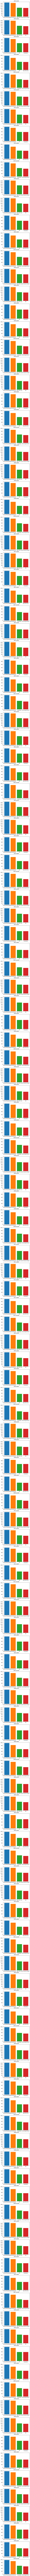

In [160]:
fig, ax = plt.subplots(len(most_common), 1, figsize=(6, 600))

i = 0
for k, v in most_common.items():
    for topic, count in v:
        ax[i].bar(topic, count)
        ax[i].set_title(k)
    i+=1
    
fig.tight_layout